
=== Relatório de Ajuste ===
[[Model]]
    Model(model_sir_accumulated)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 30
    # variables        = 3
    chi-square         = 39869167.5
    reduced chi-square = 1476635.83
    Akaike info crit   = 428.997494
    Bayesian info crit = 433.201086
    R-squared          = 0.99745149
[[Variables]]
    N:      100000 (fixed)
    beta:   0.55829198 +/- 0.03792682 (6.79%) (init = 0.3)
    gamma:  0.31824337 +/- 0.02864794 (9.00%) (init = 0.1)
    I0:     431.309050 +/- 70.8818202 (16.43%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9967
    C(beta, I0)    = -0.9581
    C(gamma, I0)   = -0.9340

=== Estimativas Chave ===
Beta (taxa de infecção): 0.5583
Gamma (taxa de recuperação): 0.3182
R0: 1.75
Total estimado de casos: 70906 (70.9% da população)


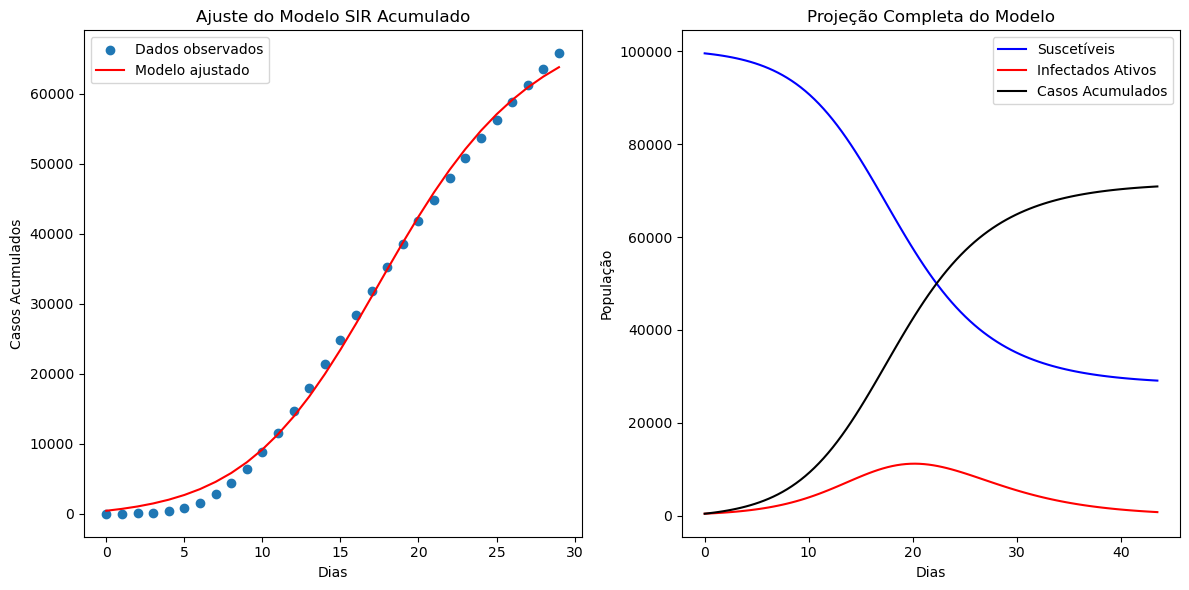

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import lmfit
import matplotlib.pyplot as plt

def sir_accumulated_model(y, t, N, beta, gamma):
    """
    Modelo SIR modificado que retorna:
    - S: Suscetíveis
    - I: Infectados ativos
    - R: Recuperados
    - C: Infectados acumulados (novo)
    """
    S, I, R, C = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dCdt = beta * S * I / N  # Novos casos por dia (derivada dos acumulados)
    return [dSdt, dIdt, dRdt, dCdt]

def model_sir_accumulated(t, N, beta, gamma, I0):
    """Wrapper para o lmfit que retorna os casos acumulados"""
    y0 = [N - I0, I0, 0, I0]  # Condições iniciais (S0, I0, R0, C0=I0)
    solution = odeint(sir_accumulated_model, y0, t, args=(N, beta, gamma))
    return solution[:, 3]  # Retorna apenas os casos acumulados (C)

def fit_sir_accumulated(t_observed, accumulated_cases, population, initial_guess=None):
    """Ajusta o modelo SIR acumulado aos dados observados"""
    
    # Configurar modelo
    mod = lmfit.Model(model_sir_accumulated, independent_vars=['t'])
    params = mod.make_params()
    
    # Parâmetros com limites físicos
    params['N'].set(value=population, vary=False)
    params['beta'].set(value=0.3, min=0.001, max=2.0)
    params['gamma'].set(value=0.1, min=0.001, max=1.0)
    params['I0'].set(value=max(1, accumulated_cases[0]), min=1, max=population)
    
    # Sobrescrever com chutes iniciais se fornecidos
    if initial_guess:
        for key, val in initial_guess.items():
            if key in params:
                params[key].set(value=val)
    
    # Ajuste do modelo
    result = mod.fit(accumulated_cases, params, t=t_observed)
    
    # Simulação final com parâmetros ajustados
    t_simulation = np.linspace(min(t_observed), max(t_observed)*1.5, 100)
    solution = odeint(sir_accumulated_model, 
                     [population - result.params['I0'].value, 
                      result.params['I0'].value, 
                      0, 
                      result.params['I0'].value], 
                     t_simulation, 
                     args=(population, result.params['beta'].value, result.params['gamma'].value))
    
    # Armazenar resultados adicionais
    result.t_simulation = t_simulation
    result.solution = solution
    result.total_cases = solution[-1, 3]  # Casos acumulados no final
    
    return result

# Exemplo de uso

# Dados de exemplo (casos acumulados por dia)
t_data = np.arange(0, 30)
C_data = np.array([10, 30, 80, 180, 380, 780, 1580, 2780, 4380, 6380, 
                  8780, 11580, 14680, 17980, 21380, 24830, 28310, 31790, 
                  35190, 38510, 41740, 44870, 47890, 50800, 53590, 56260, 58810, 61240, 63550, 65740])

N = 100000  # População total

# Executar ajuste
result = fit_sir_accumulated(t_data, C_data, N)

# Resultados
print("\n=== Relatório de Ajuste ===")
print(result.fit_report())

print("\n=== Estimativas Chave ===")
print(f"Beta (taxa de infecção): {result.params['beta'].value:.4f}")
print(f"Gamma (taxa de recuperação): {result.params['gamma'].value:.4f}")
print(f"R0: {result.params['beta'].value/result.params['gamma'].value:.2f}")
print(f"Total estimado de casos: {result.total_cases:.0f} ({result.total_cases/N:.1%} da população)")

# Visualização
plt.figure(figsize=(12, 6))

# Dados observados vs ajustados
plt.subplot(1, 2, 1)
plt.scatter(t_data, C_data, label='Dados observados')
plt.plot(t_data, result.best_fit, 'r-', label='Modelo ajustado')
plt.xlabel('Dias')
plt.ylabel('Casos Acumulados')
plt.title('Ajuste do Modelo SIR Acumulado')
plt.legend()

# Projeção completa
plt.subplot(1, 2, 2)
plt.plot(result.t_simulation, result.solution[:, 0], 'b-', label='Suscetíveis')
plt.plot(result.t_simulation, result.solution[:, 1], 'r-', label='Infectados Ativos')
plt.plot(result.t_simulation, result.solution[:, 3], 'k-', label='Casos Acumulados')
plt.xlabel('Dias')
plt.ylabel('População')
plt.title('Projeção Completa do Modelo')
plt.legend()

plt.tight_layout()
plt.show()


=== Relatório de Ajuste ===
[[Model]]
    Model(model_sir_accumulated)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 318
    # variables        = 3
    chi-square         = 1.7705e+11
    reduced chi-square = 5.6207e+08
    Akaike info crit   = 6409.77794
    Bayesian info crit = 6421.06409
    R-squared          = 0.98828800
[[Variables]]
    N:      1000000 (fixed)
    beta:   0.07432764 +/- 0.00228389 (3.07%) (init = 0.3)
    gamma:  0.04901601 +/- 0.00167486 (3.42%) (init = 0.1)
    I0:     6751.10096 +/- 540.207497 (8.00%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +0.9972
    C(beta, I0)    = -0.9539
    C(gamma, I0)   = -0.9334

=== Estimativas Chave ===
Beta (taxa de infecção): 0.0743
Gamma (taxa de recuperação): 0.0490
R0: 1.52
Total estimado de casos: 599701 (60.0% da população)


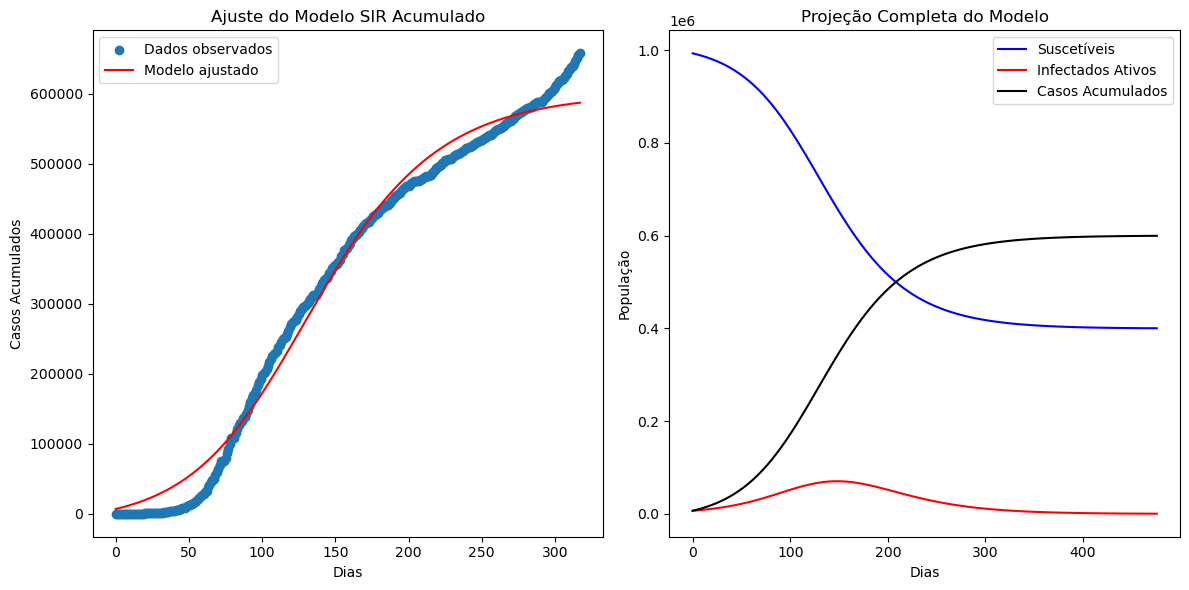

In [3]:
# Exemplo de uso
if __name__ == "__main__":
    # leitura dados
    df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
    df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')

    dfE=df0.groupby(['date', 'state'])['new_confirmed'].sum().reset_index() #agrupar por estados
    dfPA= dfE[dfE['state']=='PA' ]                                          #filtrar estado

    NCP=dfPA['new_confirmed'].values

    Cp=np.cumsum(NCP)
    t_date=dfPA['date'].values
    # periodo -01/02/2020 - 30/01/2021 (318)
    y=Cp[0:318]
    x=t_date[0:318]



    
    # Dados de exemplo (casos acumulados por dia)
    C_data=y
    t_data = np.arange(0, len(y))
    
    N = 1000000  # População total
    
    # Executar ajuste
    result = fit_sir_accumulated(t_data, C_data, N)
    
    # Resultados
    print("\n=== Relatório de Ajuste ===")
    print(result.fit_report())
    
    print("\n=== Estimativas Chave ===")
    print(f"Beta (taxa de infecção): {result.params['beta'].value:.4f}")
    print(f"Gamma (taxa de recuperação): {result.params['gamma'].value:.4f}")
    print(f"R0: {result.params['beta'].value/result.params['gamma'].value:.2f}")
    print(f"Total estimado de casos: {result.total_cases:.0f} ({result.total_cases/N:.1%} da população)")
    
    # Visualização
    plt.figure(figsize=(12, 6))
    
    # Dados observados vs ajustados
    plt.subplot(1, 2, 1)
    plt.scatter(t_data, C_data, label='Dados observados')
    plt.plot(t_data, result.best_fit, 'r-', label='Modelo ajustado')
    plt.xlabel('Dias')
    plt.ylabel('Casos Acumulados')
    plt.title('Ajuste do Modelo SIR Acumulado')
    plt.legend()
    
    # Projeção completa
    plt.subplot(1, 2, 2)
    plt.plot(result.t_simulation, result.solution[:, 0], 'b-', label='Suscetíveis')
    plt.plot(result.t_simulation, result.solution[:, 1], 'r-', label='Infectados Ativos')
    plt.plot(result.t_simulation, result.solution[:, 3], 'k-', label='Casos Acumulados')
    plt.xlabel('Dias')
    plt.ylabel('População')
    plt.title('Projeção Completa do Modelo')
    plt.legend()
    
    plt.tight_layout()
    plt.show()